# cosmology package comparison: astropy vs colossus

since `astropy.cosmology` is not complete, I usually use `colussus` for cosmology calculations. Here is a basic reference of how to use `colossus`.

We compare `astropy.cosmoloy` ('ascosmo') and `colossus` ('cosmo') for the following cosmological calculations:

In [1]:
from scipy.misc import derivative
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False

In [2]:
from astropy.cosmology import Planck15 as ascosmo
import astropy.units as u
from colossus.cosmology import cosmology

In [3]:
import os

In [24]:
path_dirout = "../data/planck18/"
if not os.path.exists(path_dirout):
    os.makedirs(path_dirout)
    print(f"Created folder: {path_dirout}")
else:
    print(f"Folder already exists: {path_dirout}")

path_pk = path_dirout + "pkl_z0.dat"
path_log10pk = path_dirout + "log10pkl_z0.dat"
path_Tk = path_dirout + "Tk_z0.dat"
print(f"Output files: {path_pk}, {path_log10pk}, {path_Tk}")

Folder already exists: ../data/planck18/
Output files: ../data/planck18/pkl_z0.dat, ../data/planck18/log10pkl_z0.dat, ../data/planck18/Tk_z0.dat


In [5]:
cosmo = cosmology.setCosmology('planck18')
# params = {
#     'flat': True,
#     'H0': 67.742,  # Hubble 参数
#     'Om0': 0.3099,  # 物质密度参数
#     'Ob0': 0.0486,  # 重子密度参数（可选）
#     'sigma8': 0.808992,  # sigma8 参数
#     'ns': 1  # 标量谱指数
# }

# cosmo = cosmology.setCosmology('myCosmo', params)

the parameters names are same.

In [25]:
h = cosmo.h
H0 = cosmo.H0 
OmM, OmL = cosmo.Om0, cosmo.Ode0
Omb = cosmo.Ob0
sigma8 = cosmo.sigma8

print(f"h = {h}, H0 = {H0}, OmM = {OmM}, OmL = {OmL}, Omb = {Omb}, sigma8 = {sigma8}, ns = {cosmo.ns}")

h = 0.6766, H0 = 67.66, OmM = 0.3111, OmL = 0.6888086135204782, Omb = 0.049, sigma8 = 0.8102, ns = 0.9665


In [7]:
ascosmo.H0

<Quantity 67.74 km / (Mpc s)>

`colussus` use unit Mpc/h, while `astropy.cosmology` use Mpc and calculate with units. 
we prepare unit Mpc/h for `colussus` here:

In [8]:
Mpc_per_h = u.def_unit('Mpc/h', u.Mpc / h)
(1*u.Mpc).to(Mpc_per_h)

<Quantity 0.6766 Mpc/h>

## H(z)

In [9]:
z=1.2
cosmo.Hz(z)*u.km/u.s/u.Mpc

<Quantity 135.379903 km / (Mpc s)>

In [10]:
ascosmo.H(z)

<Quantity 135.17733731 km / (Mpc s)>

## comoving distance

In [11]:
ascosmo.comoving_distance(z)

<Quantity 3865.80714198 Mpc>

In [12]:
d = cosmo.comovingDistance(0, z) * Mpc_per_h 
print(d, d.to(u.Mpc))

2614.9188854461822 Mpc/h 3864.7929137543333 Mpc


## time

In [13]:
cosmo.lookbackTime(1)


array(7.93548554)

In [14]:
ascosmo.lookback_time(1), ascosmo.lookback_time(4), ascosmo.lookback_time(1100)

(<Quantity 7.93506664 Gyr>,
 <Quantity 12.25651027 Gyr>,
 <Quantity 13.79724884 Gyr>)

In [15]:
ascosmo.lookback_time(11000)-ascosmo.lookback_time(1)
ascosmo.lookback_time(11000)-ascosmo.lookback_time(4)

<Quantity 1.54109993 Gyr>

## colussus-only

### growth factor

In [16]:
def GrowthRate(z):
    a = 1/(1+z)
    
    def D(a):
        z = 1/a - 1
        return cosmo.growthFactor(z) 
    
    def logarithmic_derivative(a):
        # 使用 scipy 的 derivative 函数来计算导数
        dD_da = derivative(D, a, dx=1e-6)
        # 计算对数导数
        dlnD_dlna = dD_da * a / D(a)
        return dlnD_dlna    
    
    return logarithmic_derivative(a)

def f(z):
    return GrowthRate(z)


### linear power spectrum

In [17]:
ks = np.logspace(-5, 2, 200)
pks_mz = cosmo.matterPowerSpectrum(ks, z)
pks_m0 = cosmo.matterPowerSpectrum(ks, 0)

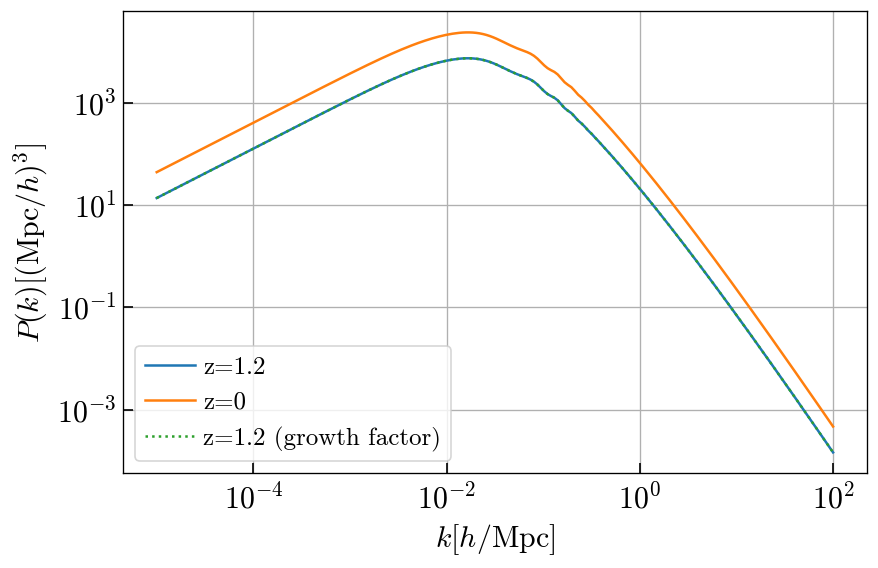

In [18]:
plt.plot(ks, pks_mz, label=f'z={z}')
plt.plot(ks, pks_m0, label=f'z=0')
plt.plot(ks, pks_m0*cosmo.growthFactor(z)**2, ':', label=f'z={z} (growth factor)')
plt.xlabel(r'$k [h/{\rm Mpc}]$')
plt.xscale('log')
plt.ylabel(r'$P(k) [({\rm Mpc}/h)^3]$')
plt.yscale('log')
plt.legend()

In [19]:
cosmo.growthFactor(49), 1/(1+49)

(array(0.02570906), 0.02)

In [20]:
np.savetxt(path_pk, np.column_stack((ks, pks_m0)))
np.savetxt(path_log10pk, np.column_stack((np.log10(ks), np.log10(pks_m0))))   

## Transfer function

2LPT-PNG need to input transfer function. 
It can normalize the transfer function, so we just output the unnormalized transfer function as $$T(k) = \sqrt{\frac{P(k)}{k}}$$

In [21]:
Tk = np.sqrt(pks_m0/ks)

In [22]:
np.savetxt(path_Tk, np.column_stack((ks, Tk)))